# CS146 Problem set: Using Stan

This Python Notebook contains the work done for the CS146 Problem Set: Using stan. 

The notebooks outline follows the assignment instructions, starting with Problem 1 Part 1

# Question 1 part 1

For this problem, I will use Stan to estimate the number of calls per minute $\lambda$ during the 13th our at a call center. More specifically, I will do this by (1) finding the 98% confidence interval from the Stan obtained posteriors of $\lambda$. 

I will use the exponential distribution as likelihood function, and the gamma distribution for my prior. 

Our known values are: 
- Waiting times for hour 13 
- prior alpha 
- prior beta

Our unknown values are: 
- Rate parameter

Our model are: 
 - likelihood: Exponential
 - Prior: Gamma

### Code cell outline:

Cell 1 - Process the data and import packages

Cell 2 - Prints a histogram over the waiting time for hour 13 

Cell 3 - Specify the data for stan and plot the prior

Cell 4 - Stan Code

Cell 5 - Sample posterior from stan model with the model data

Cell 6 - Plot posterior histogram and compute 98% confidence interval



Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


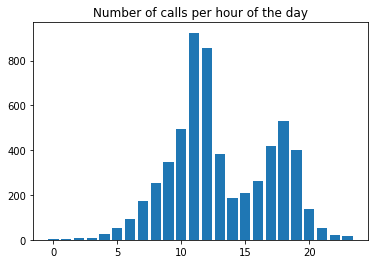

In [1]:
#import packages used for Question 1 part 1
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pystan

# Load the data set containing durations between calls arriving at the call center.
# All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Plot the number of calls per hour
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.title('Number of calls per hour of the day')
plt.show()

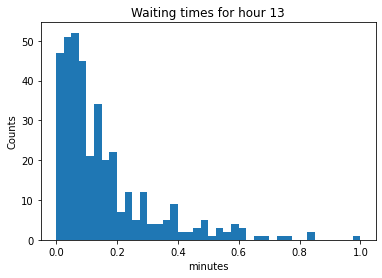

In [2]:
# Plot histogram of waiting times for hour
hour_index = 13
waiting_times_hour_13 = waiting_times_per_hour[hour_index]
plt.hist(waiting_times_hour_13, bins=40)
plt.xlabel("minutes")
plt.ylabel("Counts")
plt.title('Waiting times for hour %i' % hour_index)
plt.show()

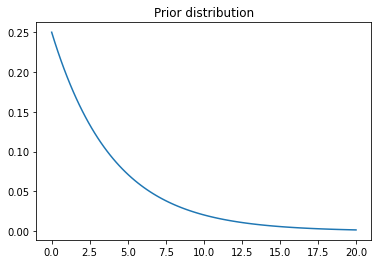

In [3]:
#Define the model data for part 1
model_data_p1 = {
        'alpha': 1,  #prior alpha 
        'beta': 0.25,   #prior beta
        'waiting_time': waiting_times_hour_13, #the waiting time data
        'number_calls': len(waiting_times_hour_13)
}

#Plot the prior
x_plot_val = np.linspace(0,20,100)
plt.figure()
plt.plot(x_plot_val, stats.gamma.pdf(x_plot_val, a = model_data_p1["alpha"], 
                                     scale = 1/model_data_p1["beta"]))
plt.title("Prior distribution")
plt.show()

In [4]:
#This is the stan code
stan_code_p1 = """
data {
    int<lower=0> number_calls; // The number of calls during hour 13
    real<lower=0> waiting_time[number_calls];  // waiting times between call for hour 13
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

parameters {
    real<lower=0> lambda;  // rate parameter or average calls per minute
}

model {
    lambda ~ gamma(alpha, beta);  // prior over lambda (Gamma function)
    for(i in 1:number_calls) {
        waiting_time[i] ~ exponential(lambda);  // likelihood function (Exponential)
    }
}

"""

In [5]:
#Compile the stan model
stan_model_p1 = pystan.StanModel(model_code=stan_code_p1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cab7f70265c023a4c507f24340fc0259 NOW.


In [6]:
#sample lambda posteriors with the model data
posterior_p1 = stan_model_p1.sampling(data=model_data_p1)

#print sample statistics
print(posterior_p1)

Inference for Stan model: anon_model_cab7f70265c023a4c507f24340fc0259.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.36  9.0e-3   0.33   5.73   6.13   6.36   6.58   7.02   1325   1.01
lp__   324.41    0.02   0.74 322.33 324.25 324.69 324.87 324.92   1899    1.0

Samples were drawn using NUTS at Thu Feb 18 11:45:47 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We note here that the Rhat is 1, which is desired.

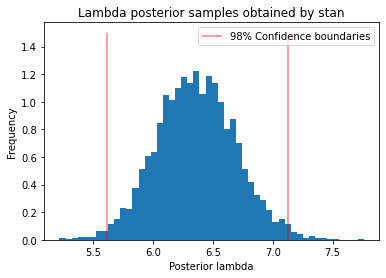

Posterior 98% interval over lambda: 5.6206859539103435 --- 7.130238192914689


In [7]:
#extract the 4000 posterior samples
posterior_p1_samples = posterior_p1.extract()
#find the 98% confidence intervall
confint = np.percentile(posterior_p1_samples['lambda'], [1, 99])

#plot the posterior sample
plt.figure()
plt.hist(posterior_p1_samples['lambda'], bins = 50, density = True)
plt.xlabel("Posterior lambda")
plt.ylabel("Frequency")
plt.title("Lambda posterior samples obtained by stan")
plt.vlines(confint,0,1.5, "r", label = "98% Confidence boundaries", alpha = 0.5)
plt.legend()
plt.show()

print(f"Posterior 98% interval over lambda: {confint[0]} --- {confint[1]}")

# Problem 1 part 2

For this problem, I will use Stan to estimate the $\mu$ and $\sigma^2$ of normally distributed data. More specifically, I will do this by (1) finding the 95% confidence interval over sampled posterior $\mu$ and $\sigma^2$. 

I will use the normal likelihood function, and the normal-inverse-gamma for my prior. 

Our known values are: 
- Normally distributed data
- prior $\mu$
- prior $\nu$
- prior $\alpha$
- prior $\beta$

Our unknown values are: 
- $\mu$
- $\sigma^2$

Our model are: 
 - likelihood: Normal
 - Prior: Normal-Inverse-Gamma prior

## Code cell outline

Cell 1 - Define all the known quantities

Cell 2 - Specify the stan model data

Cell 3 - Stan code

Cell 4 - Create stan model

Cell 5 - Sample posterior with model data

Cell 6 - Find confint for $\sigma^2$ and $\mu$ and plot results

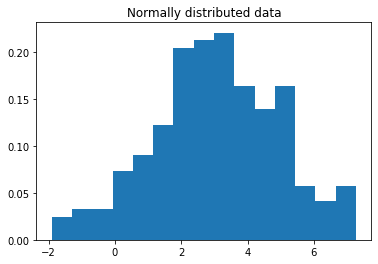

The data looks kind of normal, thus we want to use a normal likelihood function


In [8]:
#Define all the known quantities and plot the data

mu_0 = 0        # The prior mean is centered around 0.
nu_0 = 0.054    # The smaller nu_0 is, the more uncertain we are about the prior mean.
alpha_0 = 1.12  # alpha and beta govern the marginal prior over the variance.
beta_0 = 0.4

data_p2 = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
plt.hist(data_p2, density = True, bins = 15)
plt.title("Normally distributed data")
plt.show()
print("The data looks kind of normal, thus we want to use a normal likelihood function")

In [9]:
#Define the stan model data
model_data_p2 = {
    'model_data': data_p2, #The normally distributed data
    'num_data': len(data_p2), #The number of data points
    'mu_0': mu_0, #prior
    'nu_0': nu_0, #prior
    'alpha_0': alpha_0, #prior
    'beta_0': beta_0 #prior
}


In [10]:
#Stan code
stan_code_p2 = """
data {
    int<lower=0> num_data; // The number of data point
    real model_data[num_data];  // The data point
    real mu_0;              // fixed prior hyperparameter
    real<lower=0> nu_0;     // fixed prior hyperparameter
    real<lower=0> alpha_0;  // fixed prior hyperparameter
    real<lower=0> beta_0;   // fixed prior hyperparameter
}

parameters {
    real<lower=0> sigma2;  // The variance
    real mu ;              // The mean
}

model {

    sigma2 ~ inv_gamma(alpha_0, beta_0); // Prior over variance
    mu ~ normal(mu_0, sqrt(sigma2/nu_0)); // Prior over mean

    for (i in 1:num_data) {
      model_data[i] ~ normal(mu, sqrt(sigma2)); // Likelihood function
    }
}

"""

In [11]:
#Create stan model
stan_model_p2 = pystan.StanModel(model_code=stan_code_p2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7f86eb08162b00f3f32e1109cbd248a0 NOW.


In [12]:
#Sample posterior variance and mean using the normal data
posterior_p2 = stan_model_p2.sampling(data=model_data_p2)

#print the posterior statistics
print(posterior_p2)

Inference for Stan model: anon_model_7f86eb08162b00f3f32e1109cbd248a0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma2    3.6  6.8e-3   0.36   2.97   3.33   3.58   3.84   4.37   2863    1.0
mu       3.07  2.3e-3   0.13   2.81   2.98   3.06   3.15   3.32   3414    1.0
lp__   -233.2    0.02   0.97 -235.9 -233.6 -232.9 -232.5 -232.2   1794    1.0

Samples were drawn using NUTS at Thu Feb 18 11:46:52 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Note, Rhat is 1 for each parameter which is desired and points towards accurate results

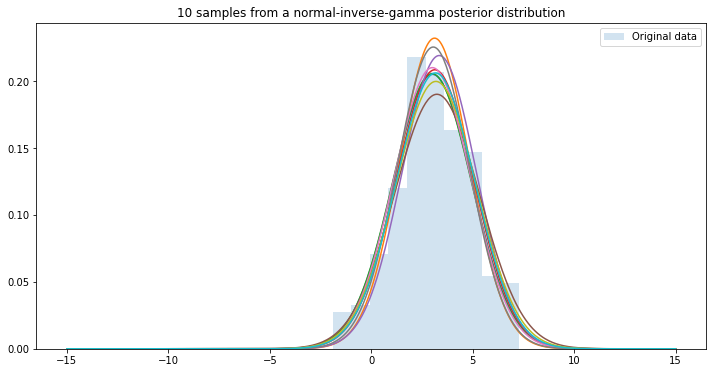

The 95% confidence interval for posterior mean is: 2.808 --- 3.317
The 95% confidence interval for posterior variance is: 2.966 --- 4.367


In [13]:
#extract the posterior sample
posterior_p2_samples = posterior_p2.extract()

#find the 95% confidence interval for mu and variance
confint_mu = np.percentile(posterior_p2_samples['mu'], [2.5, 97.5])
confint_sigma2 = np.percentile(posterior_p2_samples['sigma2'], [2.5, 97.5])

#Pick 10 samples for mu and variance without replacement from the posterior sample
posterior_10_mu = np.random.choice(posterior_p2_samples['mu'], size = 10, replace = False)
posterior_10_sigma2 = np.random.choice(posterior_p2_samples['sigma2'], size = 10, replace = False)

#plot the sampled normal distributions and the original data
plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500) #x_values
for i in range(10): #Plot the 10 sampled normal distributions
  plt.plot(plot_x, stats.norm.pdf(plot_x, loc = posterior_10_mu[i], scale = np.sqrt(posterior_10_sigma2[i])))
plt.hist(data_p2, density = True, alpha = 0.2, label = "Original data") #plot the original data
plt.title("10 samples from a normal-inverse-gamma posterior distribution")
plt.legend()
plt.show()

#Print the confidence intervals for variance and mean
print(f"The 95% confidence interval for posterior mean is: {round(confint_mu[0],3)} --- {round(confint_mu[1],3)}")
print(f"The 95% confidence interval for posterior variance is: {round(confint_sigma2[0],3)} --- {round(confint_sigma2[1],3)}")

# Problem 1 part 3

For this problem, I will use Stan to estimate the  𝜇  and  $𝜎^2$  of log-transformed data. More specifically, I will do this by (1) finding the 95% confidence interval over  𝜇  and  𝜎2 .

I will use the normal likelihood function, and the normal-inverse-gamma for my prior.

After log transforming the data, its normally distributed. I can therefore reuse the model computed for p_2, but with the new known values.

Our known values are:

- Normally distributed data
- prior  𝜇 
- prior  𝜈 
- prior  𝛼 
- prior  𝛽 

Our unknown values are:

- 𝜇 
- 𝜎2 

Our model are:

- likelihood: Normal
- Prior: Normal-Inverse-Gamma prior

### Code cell outline

Cell 1 - Transform the data

Cell 2 - Define all the known quantities

Cell 3 - Specify the stan model data

Cell 4 - Sample posterior with model data

Cell 5 - Find confint for  $𝜎^2$  and  𝜇  and plot MAP log normal distribution

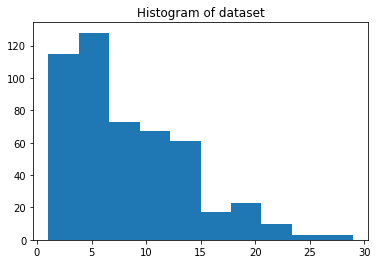

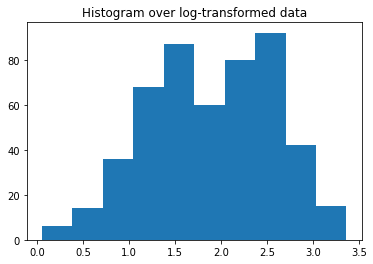

In [14]:
#import the data
data_p3 = np.loadtxt('hrtem.csv')

#plot the data
plt.hist(data_p3)
plt.title("Histogram of dataset")
plt.show()

#log transform the data
log_data_p3 = np.log(data_p3)

#plot the log transformed data
plt.hist(log_data_p3)
plt.title("Histogram over log-transformed data")
plt.show()


In [15]:
#Prior hyperparameters
mu_0_p3 = 2.3        # The prior mean is centered around 2.3.
nu_0_p3 = 0.1    
alpha_0_p3 = 2  
beta_0_p3 = 5

In [16]:
#Define the stan model data
model_data_p3 = {
    'model_data': log_data_p3, #log-transformed data (i.e. normal distributed)
    'num_data': len(log_data_p3), #number of datapoint
    'mu_0': mu_0_p3, #Prior
    'nu_0': nu_0_p3, #Prior
    'alpha_0': alpha_0_p3, #Prior
    'beta_0': beta_0_p3 #Prior
}


In [17]:
#Sample posterior variance and mean using the log-transformed data
posterior_p3 = stan_model_p2.sampling(data=model_data_p3)

#print sample statistics
print(posterior_p3)

Inference for Stan model: anon_model_7f86eb08162b00f3f32e1109cbd248a0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma2    0.5  5.1e-4   0.03   0.44   0.47   0.49   0.52   0.56   3676    1.0
mu       1.89  5.1e-4   0.03   1.83   1.87   1.89   1.91   1.95   3716    1.0
lp__    -76.0    0.02   0.98 -78.67 -76.39 -75.68 -75.29 -75.04   1664    1.0

Samples were drawn using NUTS at Thu Feb 18 11:46:54 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Please note that the Rhat is again 1 which is optimal

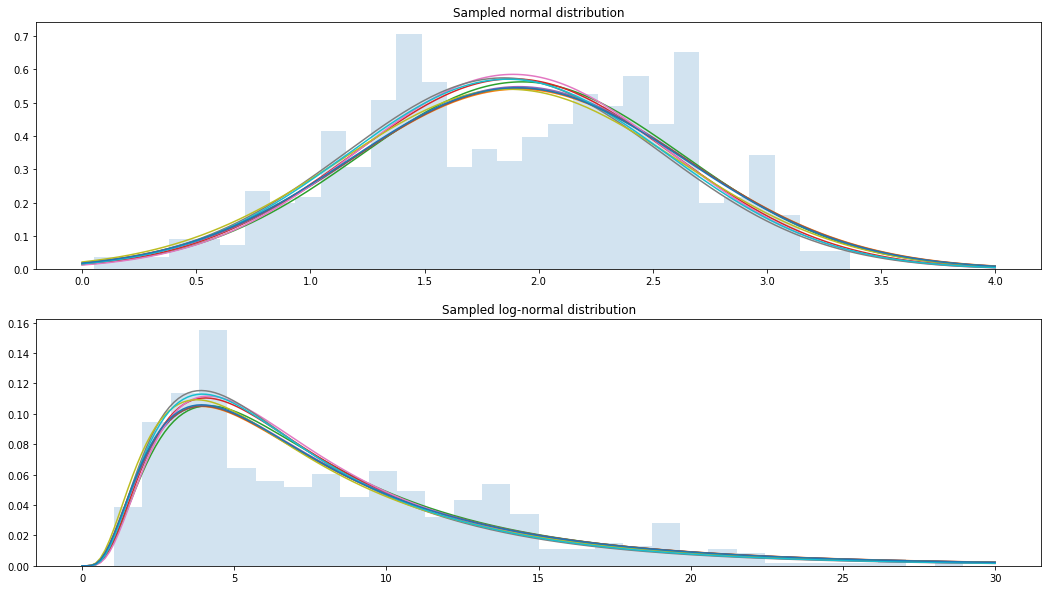

The 95% confidence interval for posterior mean is: 1.832 --- 1.953
The 95% confidence interval for posterior variance is: 0.437 --- 0.559


In [18]:
#extract the posterior sample
posterior_p3_samples = posterior_p3.extract()

#find the 95% confidence intervall
confint_mu_p3 = np.percentile(posterior_p3_samples['mu'], [2.5, 97.5])
confint_sigma2_p3 = np.percentile(posterior_p3_samples['sigma2'], [2.5, 97.5])

#sample 10 variance and mean from the sample
posterior_10_mu_p3 = np.random.choice(posterior_p3_samples['mu'], size = 10, replace = False)
posterior_10_sigma2_p3 = np.random.choice(posterior_p3_samples['sigma2'], size = 10, replace = False)

#x values
plot_log_x = np.linspace(0,4,200)
plot_x = np.linspace(0,30,200)

#plot log data and normal distribution
#create two subplots, one for log-transformed and one for original data
figure, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (18, 10))

#plot histogram over log-transformed and original data
axes[0].hist(log_data_p3, bins = 30, density = True, alpha = 0.2, label = "Log-Transformed data")
axes[1].hist(data_p3, bins = 30, density = True, alpha = 0.2, label = "Original data")

#plot the sampled normal and log-normal distributions
for i in range(len(posterior_10_mu_p3)):
  axes[0].plot(plot_log_x, stats.norm.pdf(plot_log_x, loc = posterior_10_mu_p3[i], 
                                            scale = np.sqrt(posterior_10_sigma2_p3[i])))
  axes[1].plot(plot_x, stats.lognorm.pdf(plot_x, s = np.sqrt(posterior_10_sigma2_p3[i]), 
                                           scale = np.exp(posterior_10_mu_p3[i])))

#Set the titles for the graphs
axes[0].set_title("Sampled normal distribution")
axes[1].set_title("Sampled log-normal distribution")
plt.show()

print(f"The 95% confidence interval for posterior mean is: {round(confint_mu_p3[0],3)} --- {round(confint_mu_p3[1],3)}")
print(f"The 95% confidence interval for posterior variance is: {round(confint_sigma2_p3[0],3)} --- {round(confint_sigma2_p3[1],3)}")